In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os 
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
dataset_dir = '/kaggle/input/eggs-images-classification-damaged-or-not/Eggs Classification'

classes = os.listdir(dataset_dir)
print(f"classes: {classes}")

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")

classes: ['Damaged', 'Not Damaged']
Damaged: 632 images
Not Damaged: 162 images


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), # Change shape (C, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
# Load full dataset
full_dataset = datasets.ImageFolder(root='/kaggle/input/eggs-images-classification-damaged-or-not/Eggs Classification', transform=train_transform)

# Split data 
train_ratio = 0.8
val_ratio = 0.2
total_size = len(full_dataset)
train_size = int(total_size * train_ratio)
val_size = total_size -  train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform # Override train_transform

# Create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Load model (a prestrain model)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) # for normal and break

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels =  images.to(device), labels.to(device)
        optimizer.zero_grad() # Clear the previous gradient
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() # Compute gradient (backpropagation)
        optimizer.step() # update parameter (w - n*gradient)

        running_loss += loss.item()
        _, predicted = outputs.max(1) # take the label have the highest value, ignore the valuye 
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validating
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() # sum of loss in each batch
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item() # Sum of all correct label in each batch

        val_loss = val_running_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

    # Plot metric value each epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] " 
          f"Train loss: {train_loss:.4f}, train Acc: {train_acc:.2f}% | " 
          f"Val loss: {val_loss:.4f}, val acc: {val_acc:.2f}%")

Epoch [1/20] Train loss: 0.0158, train Acc: 99.53% | Val loss: 0.0177, val acc: 100.00%
Epoch [2/20] Train loss: 0.0121, train Acc: 99.69% | Val loss: 0.0105, val acc: 100.00%
Epoch [3/20] Train loss: 0.0098, train Acc: 99.69% | Val loss: 0.0104, val acc: 100.00%
Epoch [4/20] Train loss: 0.0084, train Acc: 99.69% | Val loss: 0.0135, val acc: 100.00%
Epoch [5/20] Train loss: 0.0085, train Acc: 99.69% | Val loss: 0.0094, val acc: 100.00%
Epoch [6/20] Train loss: 0.0080, train Acc: 99.69% | Val loss: 0.0068, val acc: 100.00%
Epoch [7/20] Train loss: 0.0067, train Acc: 99.69% | Val loss: 0.0066, val acc: 100.00%
Epoch [8/20] Train loss: 0.0057, train Acc: 99.69% | Val loss: 0.0062, val acc: 100.00%
Epoch [9/20] Train loss: 0.0059, train Acc: 99.69% | Val loss: 0.0060, val acc: 100.00%
Epoch [10/20] Train loss: 0.0051, train Acc: 99.69% | Val loss: 0.0050, val acc: 100.00%
Epoch [11/20] Train loss: 0.0060, train Acc: 99.53% | Val loss: 0.0053, val acc: 100.00%
Epoch [12/20] Train loss: 0.00

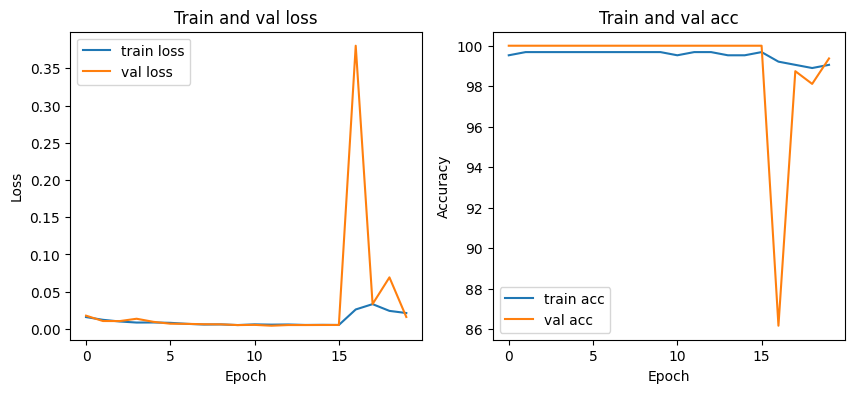

In [11]:
# plot loss and arr curve
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and val loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="train acc")
plt.plot(val_accuracies, label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train and val acc")
plt.legend()

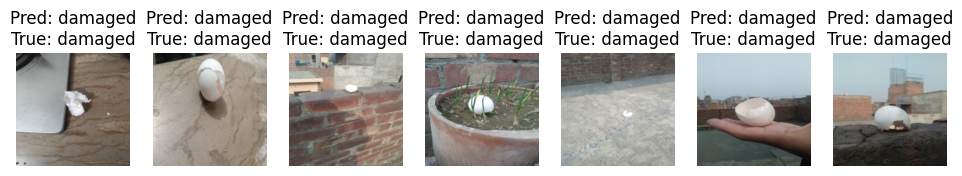

In [14]:
# Visualize val images cuz results are unreal
def imshow(img):
    img = img.cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = torch.clamp(img, 0, 1)
    npimg = img.permute(1, 2, 0).numpy()
    plt.imshow(npimg)
    plt.axis("off")

dataiter = iter(val_loader)
images, labels = next(dataiter)
classes = ["damaged", "not damaged"]

images = images.to(device)

model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(7):
    plt.subplot(1, 7, i+1)
    imshow(images[i])
    plt.title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[labels[i]]}")
    plt.axis("off")

plt.show()

In [15]:
# There is somthing wrong
# Check dataset balance

Train class distribution:
Damaged: 497
Not Damaged: 138

Validation class distribution:
Damaged: 135
Not Damaged: 24


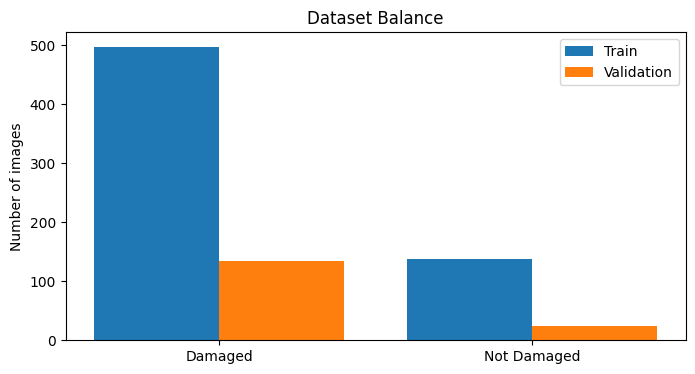

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

# Get the class names
class_names = full_dataset.classes

# Map subset indices to actual class labels
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]
val_labels = [full_dataset.targets[i] for i in val_dataset.indices]

# Count number of samples per class
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

print("Train class distribution:")
for i, count in train_counts.items():
    print(f"{class_names[i]}: {count}")

print("\nValidation class distribution:")
for i, count in val_counts.items():
    print(f"{class_names[i]}: {count}")

# --- Optional visualization ---
plt.figure(figsize=(8,4))
x = range(len(class_names))
plt.bar([i - 0.2 for i in x], [train_counts[i] for i in x], width=0.4, label='Train')
plt.bar([i + 0.2 for i in x], [val_counts[i] for i in x], width=0.4, label='Validation')
plt.xticks(x, class_names)
plt.ylabel('Number of images')
plt.title('Dataset Balance')
plt.legend()
plt.show()


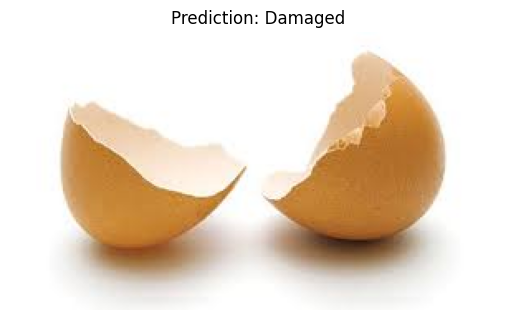

In [20]:
# 1. Load image
img_path = "/kaggle/input/broken-egg/broken-egg.jpeg"
image = Image.open(img_path).convert('RGB')

# 2. Apply same preprocessing as validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
input_tensor = val_transform(image).unsqueeze(0).to(device)

# 3. Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

class_name = full_dataset.classes[predicted.item()]

# 4. Show result
plt.imshow(Image.open(img_path))
plt.title(f"Prediction: {class_name}")
plt.axis("off")
plt.show()